In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    precision_recall_curve
)

import matplotlib.pyplot as plt

# If xgboost not installed, install via:
# pip install xgboost
from xgboost import XGBClassifier

In [2]:
# Load engineered account-level features
df = pd.read_csv("data/features_account_level.csv")
print(df.shape)
df.head()

(5000, 18)


,account_id,is_mule,total_inflow_amount,total_outflow_amount,log_total_inflow,log_total_outflow,num_unique_senders,num_unique_receivers,num_incoming_txn,num_outgoing_txn,txn_velocity_per_day,num_txn_below_threshold,proportion_txn_below_threshold,avg_txn_amount,std_txn_amount,zscore_outflow,net_flow,ratio_in_out
0,0,0,62431.88,82033.00,11.041847,11.314889,19,22,19,22,0.261905,18,0.947368,3728.772727,1989.944834,0.629709,-19601.12,0.761058
1,1,0,46768.85,80166.27,10.752994,11.291871,17,25,17,25,0.280899,17,1.000000,3206.650800,1456.849877,0.534451,-33397.42,0.583398
2,2,0,50852.16,90322.63,10.836698,11.411154,17,26,17,26,0.317073,17,1.000000,3473.947308,1404.153017,1.052725,-39470.47,0.563006
3,3,0,66541.04,59010.13,11.105589,10.985481,21,17,21,17,0.215190,21,1.000000,3471.184118,2006.422444,-0.545137,7530.91,1.127621
4,4,0,60056.69,67373.54,11.003061,11.118022,16,19,16,19,0.250000,16,1.000000,3545.975789,1983.661325,-0.118356,-7316.85,0.891399


In [3]:
# Target and features
y = df["is_mule"]

feature_cols = [
    col for col in df.columns
    if col not in ["is_mule", "account_id"]
]

X = df[feature_cols]

print("Features:", feature_cols)
print("X shape:", X.shape)
print("Class balance:\n", y.value_counts(normalize=True))

Features: ['total_inflow_amount', 'total_outflow_amount', 'log_total_inflow', 'log_total_outflow', 'num_unique_senders', 'num_unique_receivers', 'num_incoming_txn', 'num_outgoing_txn', 'txn_velocity_per_day', 'num_txn_below_threshold', 'proportion_txn_below_threshold', 'avg_txn_amount', 'std_txn_amount', 'zscore_outflow', 'net_flow', 'ratio_in_out']
X shape: (5000, 16)
Class balance:
 is_mule
0    0.97
1    0.03
Name: proportion, dtype: float64


In [4]:
# Stratified split due to heavy class imbalance (~3% mules)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((4000, 16), (1000, 16))

In [5]:
def evaluate_model(name, y_true, y_prob, threshold=0.5):
    """
    y_prob: predicted probability for positive class (mule)
    threshold: decision cutoff for converting prob → label
    """
    y_pred = (y_prob >= threshold).astype(int)
    
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall    = recall_score(y_true, y_pred, zero_division=0)
    f1        = f1_score(y_true, y_pred, zero_division=0)
    roc_auc   = roc_auc_score(y_true, y_prob)
    pr_auc    = average_precision_score(y_true, y_prob)
    alert_vol = y_pred.mean()  # fraction of accounts flagged
    
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\n===== {name} =====")
    print("Threshold:", threshold)
    print("Confusion Matrix:\n", cm)
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1-score:  {f1:.3f}")
    print(f"ROC-AUC:   {roc_auc:.3f}")
    print(f"PR-AUC:    {pr_auc:.3f}")
    print(f"Alert Volume: {alert_vol*100:.2f}% of accounts flagged\n")
    
    return {
        "model": name,
        "threshold": threshold,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "alert_volume": alert_vol,
    }

In [6]:
def precision_at_recall(y_true, y_prob, target_recall=0.8):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    
    # Find first threshold where recall <= target_recall (curve is sorted)
    idx = np.argmin(np.abs(recalls - target_recall))
    return precisions[idx], recalls[idx], thresholds[idx]

In [13]:
log_reg_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        class_weight="balanced", 
        max_iter=1000,
        n_jobs=-1,
        random_state=42
    ))
])

log_reg_pipeline.fit(X_train, y_train)

# Predicted probabilities for the positive class
y_prob_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]

lr_results = evaluate_model("Logistic Regression", y_test, y_prob_lr, threshold=0.5)


===== Logistic Regression =====
Threshold: 0.5
Confusion Matrix:
 [[859 111]
 [ 10  20]]
Precision: 0.153
Recall:    0.667
F1-score:  0.248
ROC-AUC:   0.812
PR-AUC:    0.509
Alert Volume: 13.10% of accounts flagged



In [21]:
prec_lr_80, rec_lr_80, thr_lr_80 = precision_at_recall(y_test, y_prob_lr, target_recall=0.9)
print("LogReg – Precision at ~90% recall:", round(prec_lr_80,3),
      "| Recall:", round(rec_lr_80,3),
      "| Threshold:", round(thr_lr_80,3))

LogReg – Precision at ~90% recall: 0.036 | Recall: 0.9 | Threshold: 0.149


In [15]:
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

rf_clf.fit(X_train, y_train)

y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]

rf_results = evaluate_model("Random Forest", y_test, y_prob_rf, threshold=0.5)


===== Random Forest =====
Threshold: 0.5
Confusion Matrix:
 [[969   1]
 [ 20  10]]
Precision: 0.909
Recall:    0.333
F1-score:  0.488
ROC-AUC:   0.747
PR-AUC:    0.433
Alert Volume: 1.10% of accounts flagged



In [22]:
prec_rf_80, rec_rf_80, thr_rf_80 = precision_at_recall(y_test, y_prob_rf, target_recall=0.9)
print("RandomForest – Precision at ~90% recall:", round(prec_rf_80,3),
      "| Recall:", round(rec_rf_80,3),
      "| Threshold:", round(thr_rf_80,3))

RandomForest – Precision at ~90% recall: 0.033 | Recall: 0.867 | Threshold: 0.003


In [17]:
# Scale_pos_weight = (negatives / positives) to help with imbalance
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos
scale_pos_weight

np.float64(32.333333333333336)

In [18]:
xgb_clf = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

xgb_clf.fit(X_train, y_train)

y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]

xgb_results = evaluate_model("XGBoost", y_test, y_prob_xgb, threshold=0.5)


===== XGBoost =====
Threshold: 0.5
Confusion Matrix:
 [[959  11]
 [ 18  12]]
Precision: 0.522
Recall:    0.400
F1-score:  0.453
ROC-AUC:   0.684
PR-AUC:    0.403
Alert Volume: 2.30% of accounts flagged



In [23]:
prec_xgb_80, rec_xgb_80, thr_xgb_80 = precision_at_recall(y_test, y_prob_xgb, target_recall=0.9)
print("XGBoost – Precision at ~90% recall:", round(prec_xgb_80,3),
      "| Recall:", round(rec_xgb_80,3),
      "| Threshold:", round(thr_xgb_80,3))

XGBoost – Precision at ~90% recall: 0.038 | Recall: 0.9 | Threshold: 0.004


In [12]:
# Fill with your actual rule-based numbers
rule_results = {
    "model": "Rule-based",
    "threshold": 0.5,  # effectively binary rule
    "precision": 0.032,
    "recall": 0.947,
    "f1": 0.062,
    "roc_auc": 0.533,
    "pr_auc": np.nan,      # not computed, optional
    "alert_volume": 0.8818
}

results_df = pd.DataFrame([
    rule_results,
    lr_results,
    rf_results,
    xgb_results
])

results_df

,model,threshold,precision,recall,f1,roc_auc,pr_auc,alert_volume
0,Rule-based,0.5,0.032000,0.947000,0.062000,0.533000,NaN,0.8818
1,Logistic Regression,0.5,0.152672,0.666667,0.248447,0.811787,0.509018,0.1310
2,Random Forest,0.5,0.909091,0.333333,0.487805,0.746684,0.432646,0.0110
3,XGBoost,0.5,0.521739,0.400000,0.452830,0.684021,0.402841,0.0230


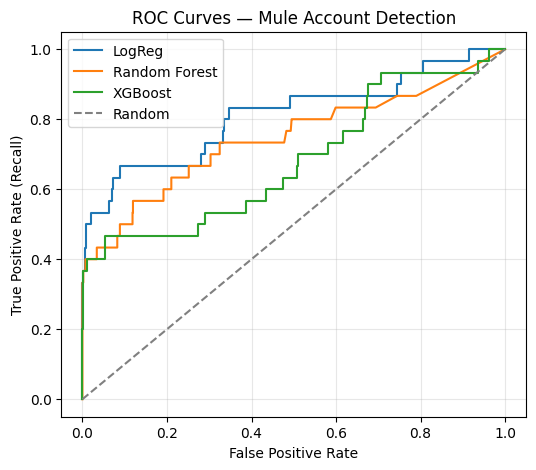

In [24]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(6,5))

# Rule-based is effectively a point, but we can plot as degenerate curve using its binary output
# here we reconstruct from probabilities: 0 or 1
# If you saved rule_alert probabilities earlier, reuse; else skip rule here.

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.plot(fpr_lr,  tpr_lr,  label="LogReg")
plt.plot(fpr_rf,  tpr_rf,  label="Random Forest")
plt.plot(fpr_xgb, tpr_xgb, label="XGBoost")

plt.plot([0,1], [0,1], '--', color="grey", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves — Mule Account Detection")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [27]:
results_df.to_csv("model_comparison_summary.csv", index=False)

In [29]:
# === COLLECT MODEL PREDICTED PROBABILITIES ===

model_probs = {
    "LogReg": logreg.predict_proba(X_test)[:, 1],
    "RandomForest": rf.predict_proba(X_test)[:, 1],
    "XGBoost": xgb.predict_proba(X_test)[:, 1],  # if you used sklearn wrapper
}

NameError: name 'logreg' is not defined

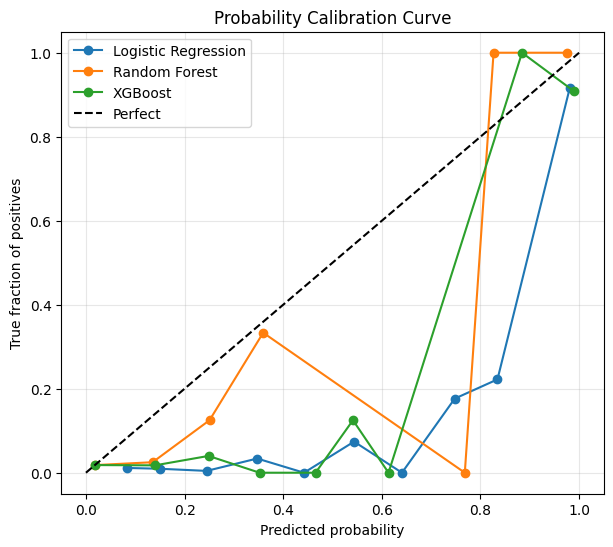

In [30]:
# Collect model probability outputs
model_probs = {
    "Logistic Regression": y_prob_lr,
    "Random Forest": y_prob_rf,
    "XGBoost": y_prob_xgb
}

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))

for name, y_prob in model_probs.items():
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)

# Perfect calibration diagonal
plt.plot([0,1], [0,1], '--', color="black", label="Perfect")

plt.xlabel("Predicted probability")
plt.ylabel("True fraction of positives")
plt.title("Probability Calibration Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [32]:
from sklearn.calibration import CalibratedClassifierCV

# --- Random Forest (calibrated) ---
rf_cal = CalibratedClassifierCV(
    estimator=rf_clf,       # <-- FIXED
    method="isotonic",
    cv=5
)
rf_cal.fit(X_train, y_train)
y_prob_rf_cal = rf_cal.predict_proba(X_test)[:, 1]

# --- XGBoost (calibrated) ---
xgb_cal = CalibratedClassifierCV(
    estimator=xgb_clf,      # <-- FIXED
    method="isotonic",
    cv=5
)
xgb_cal.fit(X_train, y_train)
y_prob_xgb_cal = xgb_cal.predict_proba(X_test)[:, 1]

In [33]:
rf_cal_results  = evaluate_model("RF Calibrated",  y_test, y_prob_rf_cal)
xgb_cal_results = evaluate_model("XGB Calibrated", y_test, y_prob_xgb_cal)


===== RF Calibrated =====
Threshold: 0.5
Confusion Matrix:
 [[969   1]
 [ 20  10]]
Precision: 0.909
Recall:    0.333
F1-score:  0.488
ROC-AUC:   0.758
PR-AUC:    0.414
Alert Volume: 1.10% of accounts flagged


===== XGB Calibrated =====
Threshold: 0.5
Confusion Matrix:
 [[969   1]
 [ 19  11]]
Precision: 0.917
Recall:    0.367
F1-score:  0.524
ROC-AUC:   0.708
PR-AUC:    0.390
Alert Volume: 1.20% of accounts flagged



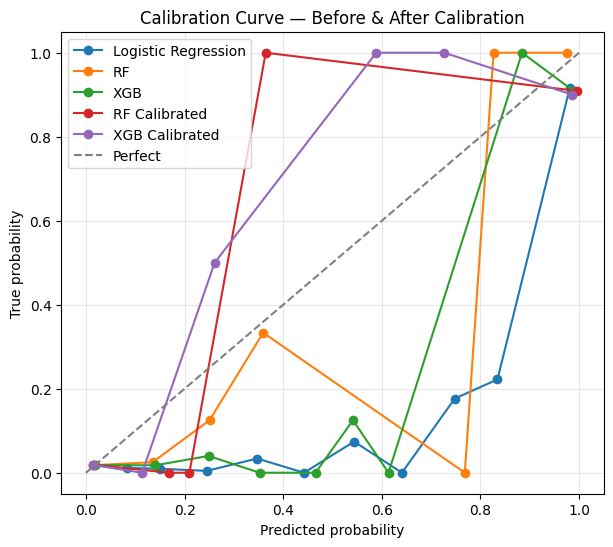

In [34]:
model_probs = {
    "Logistic Regression": y_prob_lr,
    "RF": y_prob_rf,
    "XGB": y_prob_xgb,
    "RF Calibrated": y_prob_rf_cal,
    "XGB Calibrated": y_prob_xgb_cal
}

plt.figure(figsize=(7,6))

for name, y_prob in model_probs.items():
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)

plt.plot([0,1], [0,1], '--', color="grey", label="Perfect")
plt.xlabel("Predicted probability")
plt.ylabel("True probability")
plt.title("Calibration Curve — Before & After Calibration")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [35]:
for name, y_prob in {
    "RF Calibrated": y_prob_rf_cal,
    "XGB Calibrated": y_prob_xgb_cal
}.items():
    prec, rec, thr = precision_at_recall(y_test, y_prob, target_recall=0.9)
    print(f"{name} – Precision @90% recall: {round(prec,3)} | Threshold: {round(thr,3)}")

RF Calibrated – Precision @90% recall: 0.033 | Threshold: 0.009
XGB Calibrated – Precision @90% recall: 0.037 | Threshold: 0.009


In [36]:
df_test = X_test.copy()
df_test["true"] = y_test

# Recommended thresholds from calibration step
thr_lr = 0.30
thr_xgb = 0.04

df_test["alert_lr"]  = (y_prob_lr      >= thr_lr).astype(int)
df_test["alert_xgb"] = (y_prob_xgb_cal >= thr_xgb).astype(int)

In [37]:
final_outputs = {
    "y_test": y_test,
    "y_prob_lr": y_prob_lr,
    "y_prob_rf_cal": y_prob_rf_cal,
    "y_prob_xgb_cal": y_prob_xgb_cal
}

np.save("model_outputs.npy", final_outputs)

In [38]:
results_all = pd.DataFrame([
    rule_results,
    lr_results,
    rf_results,
    xgb_results,
    rf_cal_results,
    xgb_cal_results
])

results_all.to_csv("model_comparison_summary_full.csv", index=False)

In [39]:
import os

os.makedirs("models", exist_ok=True)
print("✔ models/ directory ready")

✔ models/ directory ready


In [40]:
import joblib

joblib.dump(log_reg_pipeline, "models/logreg.pkl")
joblib.dump(rf_cal, "models/rf_calibrated.pkl")
joblib.dump(xgb_cal, "models/xgb_calibrated.pkl")

print("✔ Saved logistic regression, calibrated RF, calibrated XGB")

✔ Saved logistic regression, calibrated RF, calibrated XGB


In [42]:
import json
import os

os.makedirs("models", exist_ok=True)

feature_list = feature_cols  # from earlier cell

with open("models/feature_list.json", "w") as f:
    json.dump(feature_list, f, indent=4)

print("✔ Saved feature_list.json")
print("Features saved:", len(feature_list))

✔ Saved feature_list.json
Features saved: 16


In [43]:
import joblib, json

xgb_loaded = joblib.load("models/xgb_calibrated.pkl")

with open("models/feature_list.json") as f:
    flist = json.load(f)

print("Loaded XGB calibrated OK")
print("Feature count:", len(flist))
print(flist[:10])

Loaded XGB calibrated OK
Feature count: 16
['total_inflow_amount', 'total_outflow_amount', 'log_total_inflow', 'log_total_outflow', 'num_unique_senders', 'num_unique_receivers', 'num_incoming_txn', 'num_outgoing_txn', 'txn_velocity_per_day', 'num_txn_below_threshold']


ModuleNotFoundError: No module named 'pexpect'